<a href="https://colab.research.google.com/github/emiliopugnaloni/Crimenes-Caba/blob/main/4%20-%20Causality%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade numpy pandas
!pip install tfcausalimpact

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is incompatible.
gensim 4

## **Librerias**

In [ ]:
import pandas as pd
from causalimpact import CausalImpact
import matplotlib.pyplot as plt
import seaborn as sns

## **Import Dataset & Pre-Process**

In [ ]:
# Import Dataset
df = pd.read_csv('datos_hurto_robo.csv', index_col = 0)

# Standarize Comuna Column
df['Comuna'] = df['comuna'].astype('str')
df['Comuna'] = df['Comuna'].str.replace('CC-','').str.replace(' SUR','').str.replace(' NORTE','').str.replace('.0','')
df = df[(df.Comuna != 'nan') & (df.Comuna != 'Sin geo')]
df['Comuna'] = df['Comuna'].str.strip().astype('int')

# Change in Fecha and create Week column
df['fecha'] = pd.to_datetime(df['fecha'])
start_date = df['fecha'].min()
df['Week'] = ((df['fecha'] - start_date).dt.days // 7) + 1

# Drop unused columns
df = df.drop(['subtipo', 'latitud', 'longitud', 'comuna'], axis = 1)

# Delete data from last Week (to avoid uncompleted weeks)
max_week = df['Week'].max()
print(df.shape)
df = df[df.Week < max_week]
print(df.shape)


<ipython-input-3-0d11fd6e8322>:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datos_hurto_robo.csv', index_col = 0)


(318213, 10)
(317280, 10)


In [ ]:
print("Cantidad de Filas: ", df.shape[0])
df.head(2)

Cantidad de Filas:  317280


,anio,mes,dia,fecha,franja,tipo,barrio,No_Laborable,Comuna,Week
1,2023,enero,JUE,2023-01-12,18.0,Hurto,VILLA LUGANO,0,8,106
2,2023,enero,MIE,2023-01-18,19.0,Robo,VILLA LUGANO,0,8,107


## **Causality Analysis**

* Inaguracion de Comisaria Comunal N°3: 27 de Septiembre de 2023

  https://buenosaires.gob.ar/noticias/el-jefe-de-gobierno-inauguro-la-nueva-comisaria-comunal-ndeg-3

* Inaguracion de Comisaria Comunal N°9: 6 de Mayo de 2022

  https://buenosaires.gob.ar/noticias/se-inauguro-la-comisaria-comunal-9-en-un-punto-estrategico-de-la-ciudad

In [ ]:
# Variables to reference the date
df['Inaguracion_CC3'] = 0
df.loc[df['fecha'] >= '2023-09-27', 'Inaguracion_CC3'] = 1

df['Inaguracion_CC9'] = 0
df.loc[df['fecha'] >= '2022-05-06', 'Inaguracion_CC9'] = 1

<ipython-input-5-57050c087263>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Inaguracion_CC3'] = 0
<ipython-input-5-57050c087263>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Inaguracion_CC9'] = 0


In [ ]:
# Group data by Week and Comuna:
df_comuna_week = df.groupby(['Comuna', 'Week']).agg({'Inaguracion_CC3': 'min', 'Inaguracion_CC9': 'min', 'fecha' : 'min', 'tipo': 'count'}).reset_index()
df_comuna_week = df_comuna_week.rename(columns={'tipo': 'cant'})
df_comuna_week = df_comuna_week.rename(columns={'fecha': 'fecha_inicio'})
df_comuna_week['Comuna'] = df_comuna_week['Comuna'].astype('str')

df_comuna_week.head(10)

,Comuna,Week,Inaguracion_CC3,Inaguracion_CC9,fecha_inicio,cant
0,1,1,0,0,2021-01-01,160
1,1,2,0,0,2021-01-08,147
2,1,3,0,0,2021-01-15,143
3,1,4,0,0,2021-01-22,148
4,1,5,0,0,2021-01-29,147
5,1,6,0,0,2021-02-05,187
6,1,7,0,0,2021-02-12,145
7,1,8,0,0,2021-02-19,146
8,1,9,0,0,2021-02-26,151
9,1,10,0,0,2021-03-05,180


<Axes: xlabel='Week', ylabel='cant'>

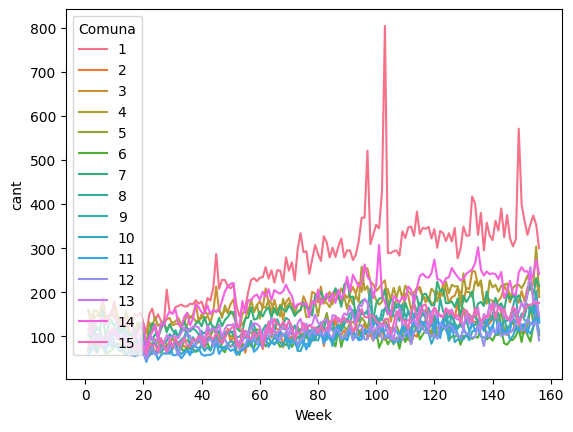

In [ ]:
# Plot lineplot separated by Comuna
sns.lineplot(data=df_comuna_week, x="Week", y="cant", hue="Comuna")

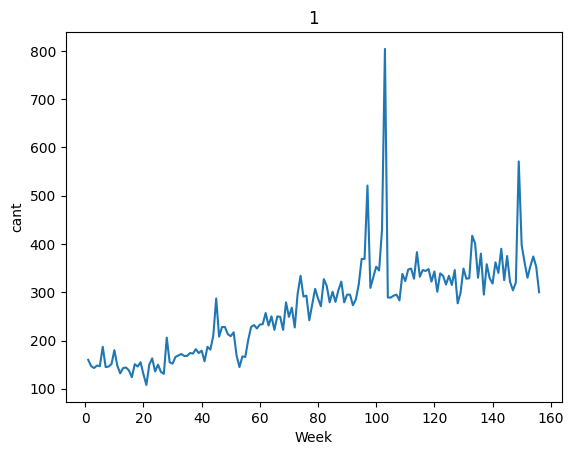

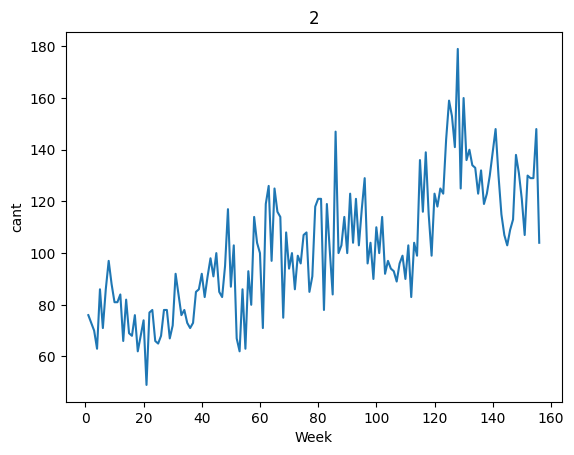

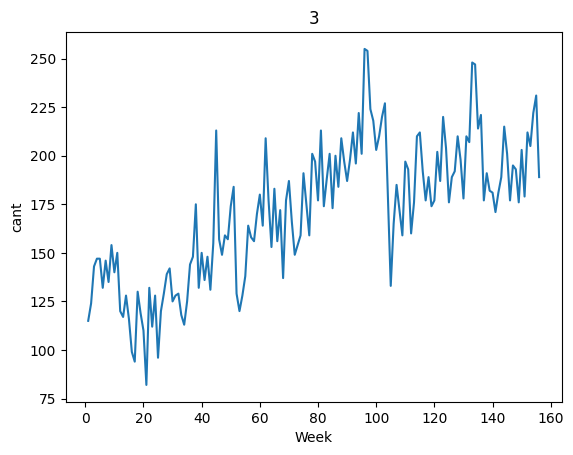

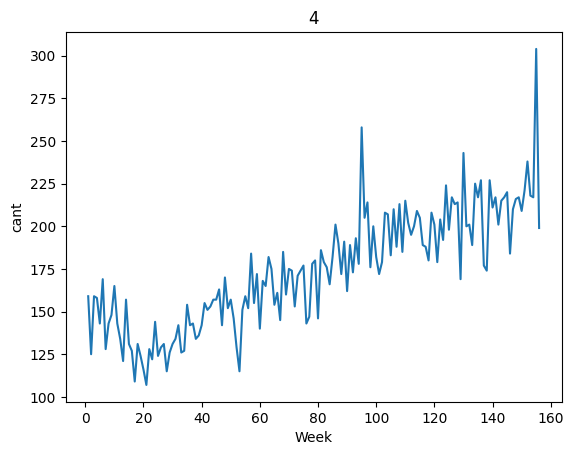

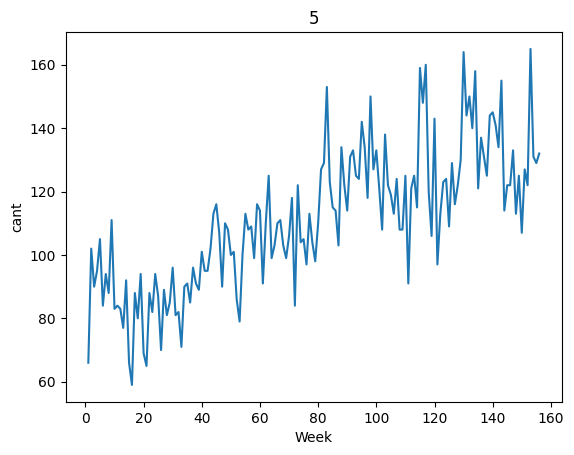

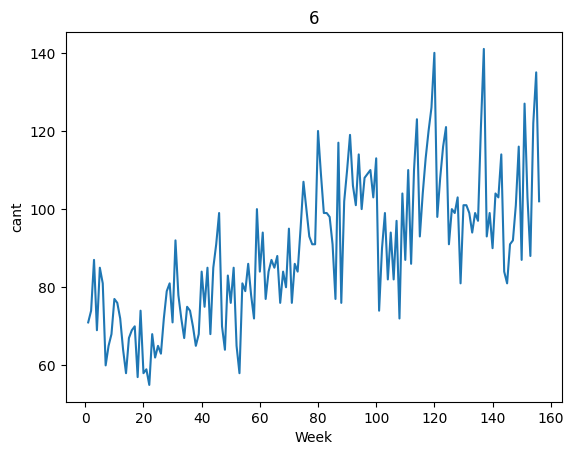

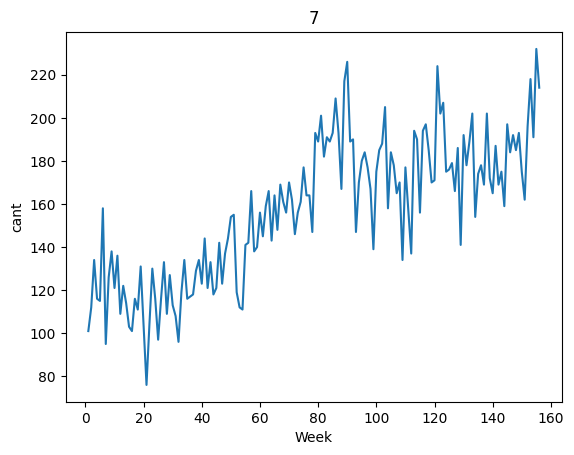

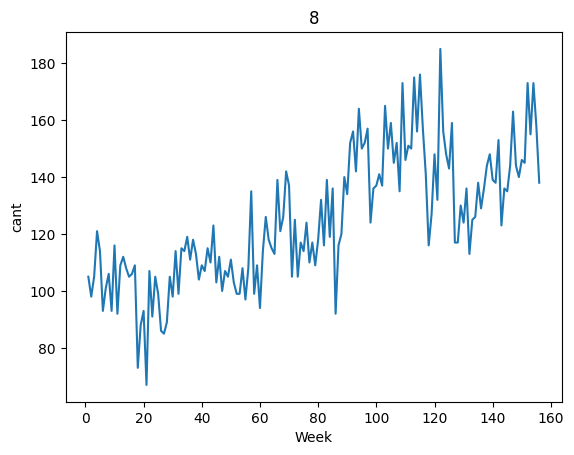

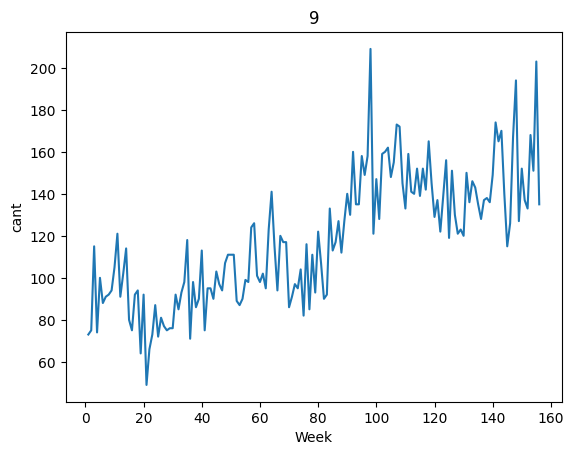

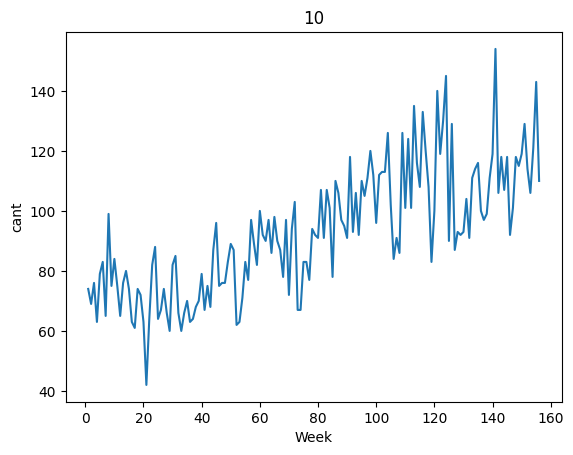

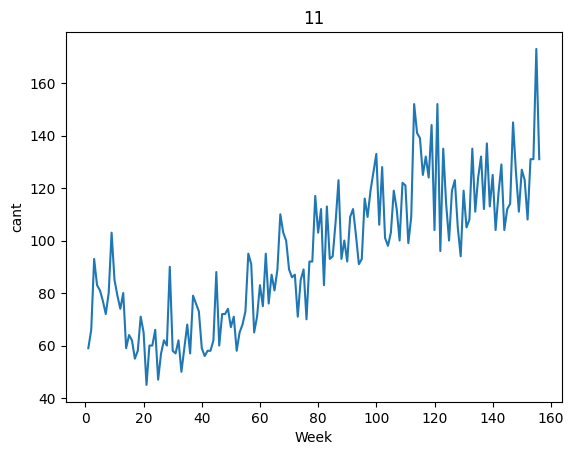

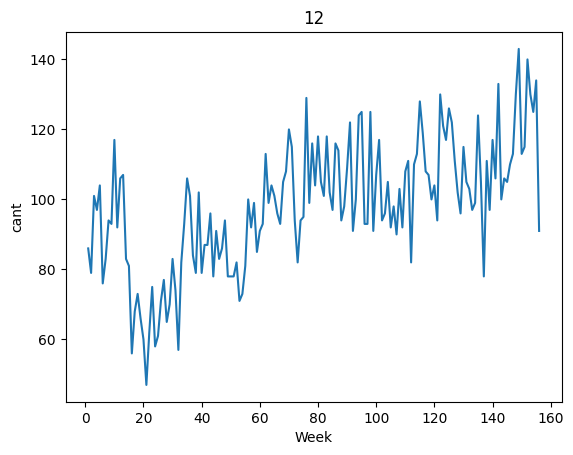

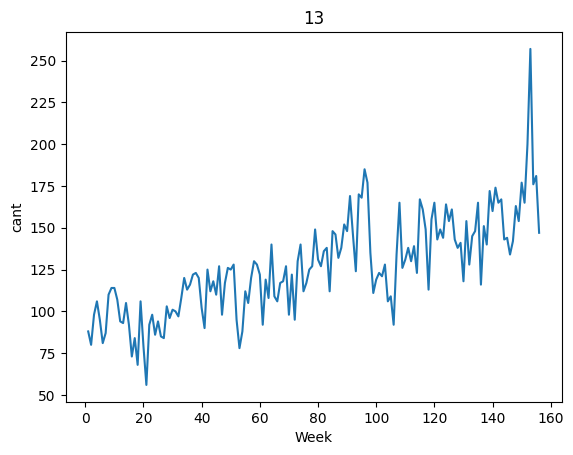

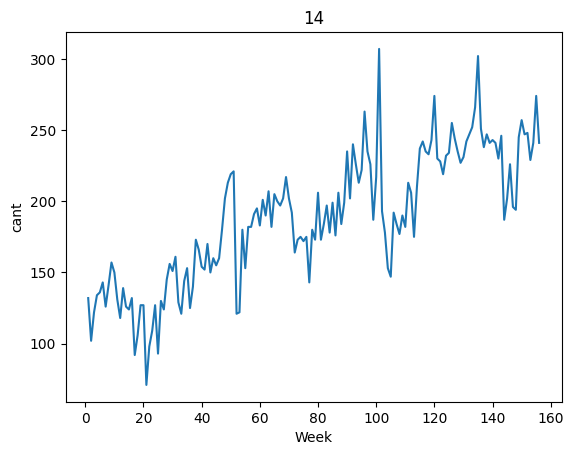

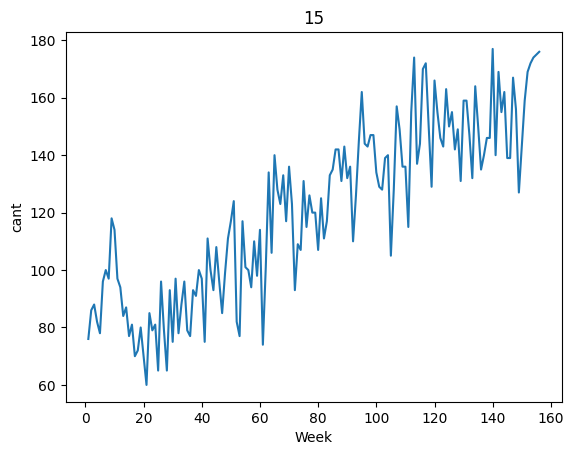

In [ ]:
for comuna in df_comuna_week.Comuna.unique():
  sns.lineplot(data=df_comuna_week[df_comuna_week.Comuna == comuna], x="Week", y="cant")
  plt.title(comuna)
  plt.show()

In [ ]:
# Pivot by Comunas
df_comuna_week_pivot = df_comuna_week.pivot(index='Week', columns='Comuna', values='cant')
df_comuna_week_pivot.head(3)

Comuna,1,10,11,12,13,14,15,2,3,4,5,6,7,8,9
Week,,,,,,,,,,,,,,,
1,160,74,59,86,88,132,76,76,115,159,66,71,101,105,73
2,147,69,66,79,80,102,86,73,124,125,102,74,112,98,75
3,143,76,93,101,98,122,88,70,143,159,90,87,134,105,115


### **Causality CC3**


In [ ]:
# Create Data. Fist colum is the Y, the others are th X

data = pd.concat( [df_comuna_week_pivot[['3']], df_comuna_week_pivot.drop(['3', '9'], axis = 1)], axis = 1)
data = data.reset_index()
data = data.drop(['Week'], axis = 1)
data.head(2)

Comuna,3,1,10,11,12,13,14,15,2,4,5,6,7,8
0,115,160,74,59,86,88,132,76,76,159,66,71,101,105
1,124,147,69,66,79,80,102,86,73,125,102,74,112,98


In [ ]:
# Define the pre_period or post_period

min_week = df_comuna_week.loc[df_comuna_week['Inaguracion_CC3'] == 1, 'Week'].min()
pre_period = [0, min_week -1]
post_period = [min_week, len(df_comuna_week_pivot)-1]

In [ ]:
ci = CausalImpact(data, pre_period, post_period)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


In [ ]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    198.58             2383.0
Prediction (s.d.)         207.74 (8.83)      2492.93 (105.96)
95% CI                    [192.33, 226.94]   [2307.97, 2723.33]

Absolute effect (s.d.)    -9.16 (8.83)       -109.93 (105.96)
95% CI                    [-28.36, 6.25]     [-340.33, 75.03]

Relative effect (s.d.)    -4.41% (4.25%)     -4.41% (4.25%)
95% CI                    [-13.65%, 3.01%]   [-13.65%, 3.01%]

Posterior tail-area probability p: 0.13
Posterior prob. of a causal effect: 86.81%

For more details run the command: print(impact.summary('report'))


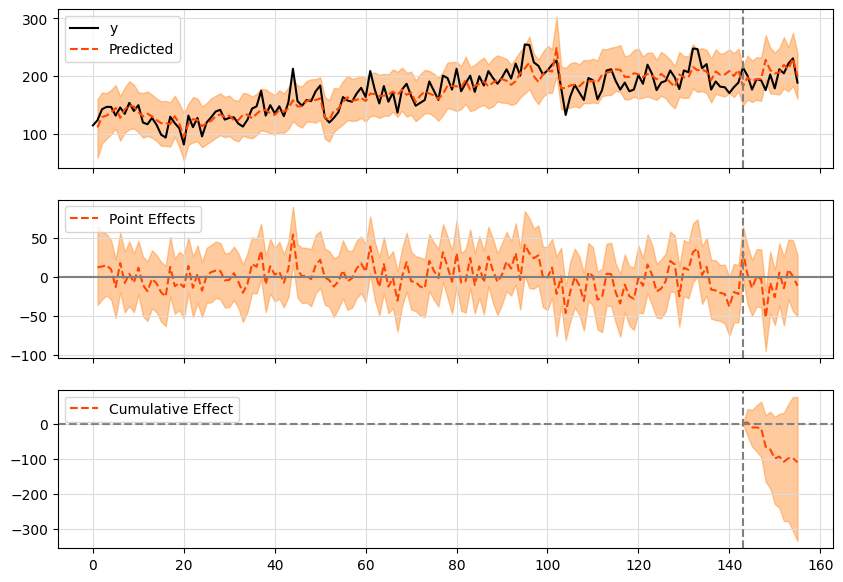

In [ ]:
ci.plot()

In [ ]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 198.58. In the absence of an
intervention, we would have expected an average response of 207.74.
The 95% interval of this counterfactual prediction is [192.33, 226.94].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -9.16 with a 95% interval of
[-28.36, 6.25]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2383.0.
Had the intervention not taken place, we would have expected
a sum of 2492.93. The 95% interval of this prediction is [2307.97, 2723.33].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decreas

### **Causality CC9**

In [ ]:
# Create Data. Fist colum is the Y, the others are th X

data = pd.concat( [df_comuna_week_pivot[['9']], df_comuna_week_pivot.drop(['3', '9'], axis = 1)], axis = 1)
data = data.reset_index()
data = data.drop(['Week'], axis = 1)
data.head(2)

# Define the pre_period or post_period
min_week = df_comuna_week.loc[df_comuna_week['Inaguracion_CC9'] == 1, 'Week'].min()
pre_period = [0, min_week -1]
post_period = [min_week, len(df_comuna_week_pivot)-1]

In [ ]:
ci = CausalImpact(data, pre_period, post_period)

In [ ]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    138.08             11737.0
Prediction (s.d.)         118.18 (12.97)     10044.89 (1102.03)
95% CI                    [94.87, 145.69]    [8064.12, 12383.99]

Absolute effect (s.d.)    19.91 (12.97)      1692.11 (1102.03)
95% CI                    [-7.61, 43.21]     [-646.99, 3672.88]

Relative effect (s.d.)    16.85% (10.97%)    16.85% (10.97%)
95% CI                    [-6.44%, 36.56%]   [-6.44%, 36.56%]

Posterior tail-area probability p: 0.06
Posterior prob. of a causal effect: 93.51%

For more details run the command: print(impact.summary('report'))


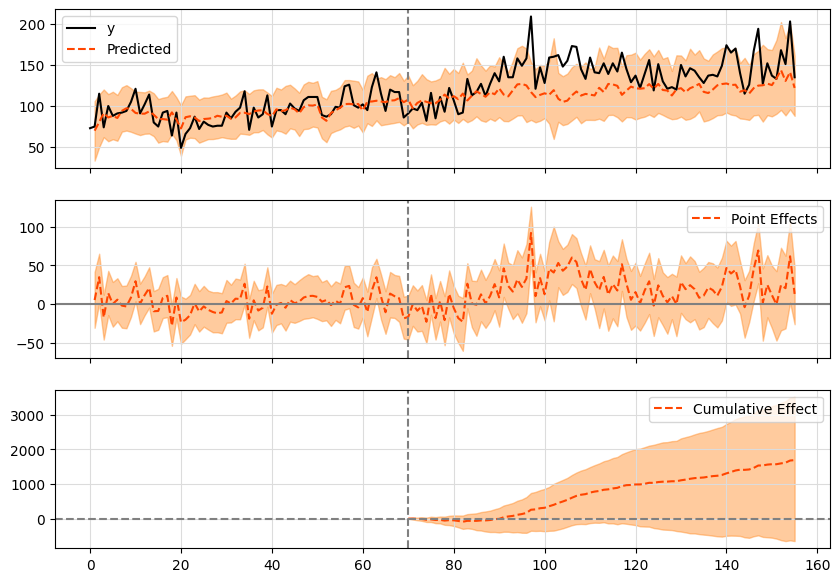

In [ ]:
ci.plot()

In [ ]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 138.08. In the absence of an
intervention, we would have expected an average response of 118.18.
The 95% interval of this counterfactual prediction is [94.87, 145.69].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 19.91 with a 95% interval of
[-7.61, 43.21]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 11737.0.
Had the intervention not taken place, we would have expected
a sum of 10044.89. The 95% interval of this prediction is [8064.12, 12383.99].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incr